# Sentiment analysis for health authority feedback


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score, plot_confusion_matrix

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

import shap

In [2]:
data = pd.read_csv("../data/sentences_with_sentiment_preprocessed.csv", index_col="ID")

### 0. Train-test split

In [3]:
# train test split
train, test = train_test_split(data, shuffle = True, stratify = data.Label, train_size = 0.8)
train.shape, test.shape

((212, 4), (54, 4))

### 1. Embeddings
**BOW Embedding**

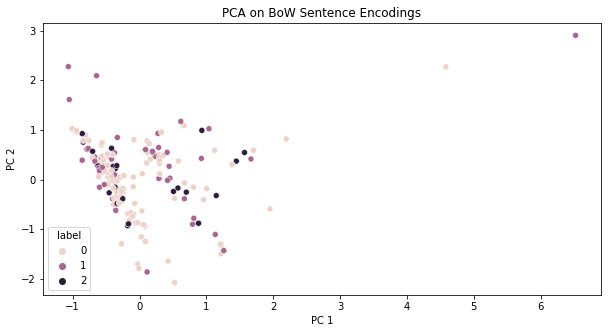

In [4]:
bow = CountVectorizer()
x_train = bow.fit_transform(train.Stemmed_sentence.values)
x_test = bow.transform(test.Stemmed_sentence.values)
x_test = shuffle(x_test)


# Visualice Embedding (PCA)
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(x_train.todense())
pca_data = pd.DataFrame(pca_data, columns = ["PC 1", "PC 2"])
pca_data["label"] = train.Label.values

fig, ax = plt.subplots( figsize=(10,5))
ax = sns.scatterplot(x = "PC 1", y = "PC 2", data = pca_data, hue = "label")
plt.title("PCA on BoW Sentence Encodings")
plt.savefig("../plots/PCA_BOW.jpg", bbox_inches='tight')
plt.show()

**TF-IDF**

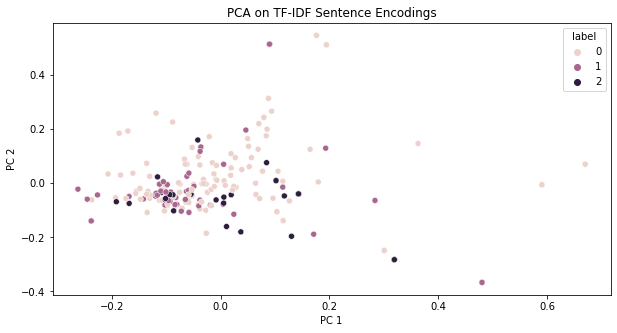

In [5]:
tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(train.Stemmed_sentence.values)
x_test = tfidf.transform(test.Stemmed_sentence.values)
x_test = shuffle(x_test)

# Visualice Embedding (PCA)
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(x_train.todense())
pca_data = pd.DataFrame(pca_data, columns = ["PC 1", "PC 2"])
pca_data['label'] = train.Label.values

fig, ax = plt.subplots( figsize=(10,5))
ax = sns.scatterplot(x = "PC 1", y = "PC 2", data = pca_data, hue = "label")
plt.title("PCA on TF-IDF Sentence Encodings")
plt.savefig("../plots/PCA_TF-IDF.jpg", bbox_inches='tight')
plt.show()

**Word Vectors (GLOVE, Word2Vec)**

## 2. Modell building

In [6]:
def print_metrics(y_test, y_pred):
    # calculate metrics
    f1 = f1_score(y_test, y_pred, average = "weighted")
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average = "weighted")
    precision = precision_score(y_test, y_pred, average = "weighted")
    
    print("F1: {:.3f} | Accuracy: {:.3f} | Recall: {:.3f} | Precision: {:.3f} \n".format(f1, acc, recall, precision))
    
def print_confusion_matrix(model, x_test, y_test, model_name=None):
    plot_confusion_matrix(model, x_test, y_test)
    if model_name:
        plt.savefig("../plots/cfmatrix_{}.jpg".format(model_name), bbox_inches="tight")
    plt.show()

**Prediction with Tf-IDF Embedding**

In [7]:
y_train = train.Label.values
y_test = test.Label.values

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(train.Stemmed_sentence.values)
x_test = tfidf.transform(test.Stemmed_sentence.values)

### 2.1 Logistic regression modell

F1: 0.641 | Accuracy: 0.667 | Recall: 0.667 | Precision: 0.637 



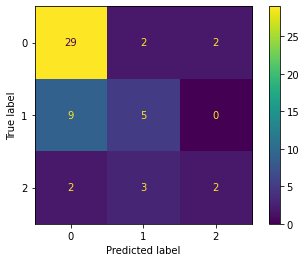

In [8]:
# Logisitc Regression
lr = SGDClassifier(loss = "log")
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

print_metrics(y_test, y_pred)
print_confusion_matrix(lr, x_test, y_test)

**How does the Model comes to decision? Shap values**

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


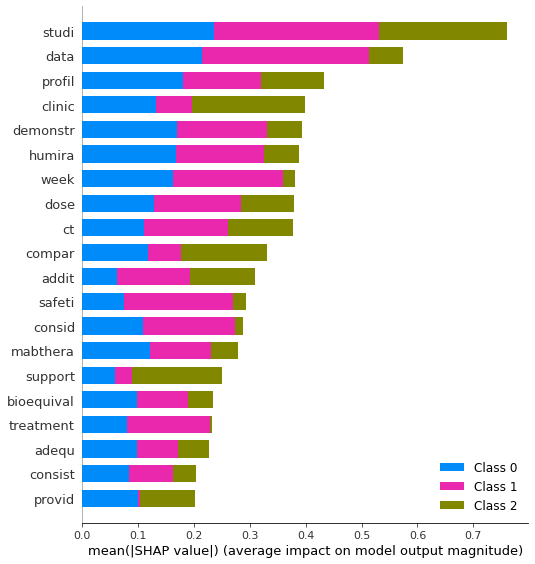

In [9]:
explainer = shap.LinearExplainer(lr, x_train, feature_dependence="independent")
shap_values = explainer.shap_values(x_test)

shap.initjs()

shap.summary_plot(shap_values, x_test, show=False, feature_names=tfidf.get_feature_names())
plt.savefig("../plots/shap_values_log_reg.jpg", bbox_inches="tight")

In [10]:
# Expected values by classes in logistic regression
explainer.expected_value

array([ 1.19809655, -2.13503447, -3.48739709])

## 2.2 Train different ML-models

Training LR
F1: 0.641 | Accuracy: 0.667 | Recall: 0.667 | Precision: 0.637 



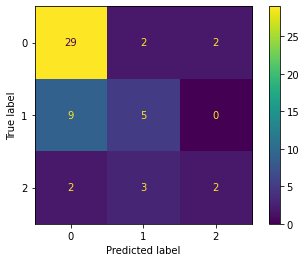

Training SVM
F1: 0.538 | Accuracy: 0.648 | Recall: 0.648 | Precision: 0.525 



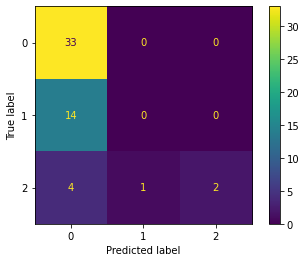

Training NB
F1: 0.532 | Accuracy: 0.648 | Recall: 0.648 | Precision: 0.517 



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


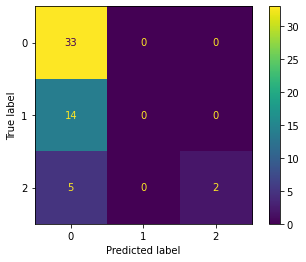

Training KNN
F1: 0.509 | Accuracy: 0.537 | Recall: 0.537 | Precision: 0.493 



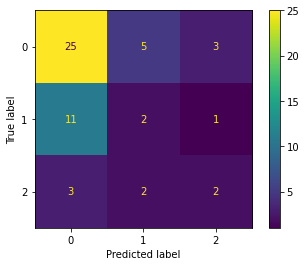

Training RForest
F1: 0.538 | Accuracy: 0.648 | Recall: 0.648 | Precision: 0.525 



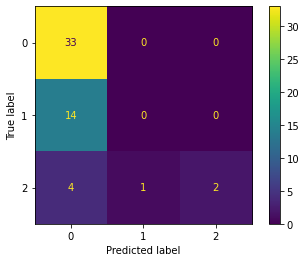

Training XGB
[19:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


F1: 0.557 | Accuracy: 0.593 | Recall: 0.593 | Precision: 0.589 



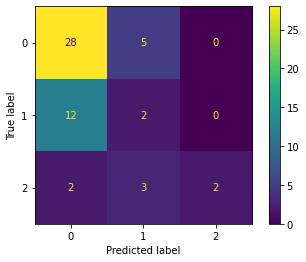

In [11]:
lr = SGDClassifier(loss="log")
svm = SVC(C = 1, kernel="rbf", probability=True)
nb = MultinomialNB(class_prior=[0.6, 0.2, 0.2])
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
rforest = RandomForestClassifier(n_estimators=100)
xgb = XGBClassifier(n_estimators=100)

model_dict = dict(zip(["LR", "SVM", "NB", "KNN", "RForest", "XGB"], [lr, svm, nb, knn, rforest, xgb]))

for model_name, model in model_dict.items():
    print("Training {}".format(model_name))
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    # print metrics
    print_metrics(y_test, y_pred)
    print_confusion_matrix(model, x_test, y_test, model_name)